# Binary classification models

In [1]:
# Standard library imports
from typing import Tuple

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

2025-01-16 20:34:49.326718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)
data_df.head()

,state,incidents,year,month
0,AK,0,1953,10
1,AK,0,1953,11
2,AK,0,1953,12
3,AK,0,1954,1
4,AK,0,1954,2


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43639 entries, 0 to 43638
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      43639 non-null  object
 1   incidents  43639 non-null  int64 
 2   year       43639 non-null  int64 
 3   month      43639 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [4]:
print(f"\nHave {data_df['incidents'].sum()} total disaster incidents")


Have 41865 total disaster incidents


## 2. Data preparation

### 2.1. Create multiindex

In [5]:
indexes=[
    data_df['year'].tolist(),
    data_df['state'].tolist(),
    data_df['month'].tolist()
]

index_tuples=list(zip(*indexes))
index=pd.MultiIndex.from_tuples(index_tuples, names=['Year', 'State', 'Month'])
data_df.set_index(index, inplace=True)
data_df.head()

state  incidents  year  month
Year State Month                              
1953 AK    10       AK          0  1953     10
           11       AK          0  1953     11
           12       AK          0  1953     12
1954 AK    1        AK          0  1954      1
           2        AK          0  1954      2

### 2.2. Cyclical month encoding

In [6]:
# Define a helper function here so we can encode the time
# features the same way on the training and testing data
# without copy-pasting the same code
def encode_month(data_df: pd.DataFrame) -> pd.DataFrame:
    '''Takes a Pandas dataframe and uses cyclical sin/cos to encode
    month feature. Returns updated dataframe.'''

    data_df['month_sin'] = np.sin(2 * np.pi * data_df['month']/12.0)
    data_df['month_cos'] = np.cos(2 * np.pi * data_df['month']/12.0)

    # Drop the original string features
    data_df.drop(['month'], axis=1, inplace=True)

    return data_df

In [7]:
data_df=encode_month(data_df)
data_df.head()

state  incidents  year     month_sin  month_cos
Year State Month                                                
1953 AK    10       AK          0  1953 -8.660254e-01   0.500000
           11       AK          0  1953 -5.000000e-01   0.866025
           12       AK          0  1953 -2.449294e-16   1.000000
1954 AK    1        AK          0  1954  5.000000e-01   0.866025
           2        AK          0  1954  8.660254e-01   0.500000

### 2.2. Dummy encode state

Can't decide if I want this one or not - for actual timeseries models, the state will never change in a batch. But for simple logistic regression, it might be useful to have it. Let's do it, we can always just drop the columns later if we decide we don't want it.

In [8]:
states=pd.get_dummies(data_df['state'], dtype=int)
states.head()

AK  AL  AR  AS  AZ  CA  CO  CT  DC  DE  ...  TN  TX  UT  VA  \
Year State Month                                          ...                   
1953 AK    10      1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
           11      1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
           12      1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
1954 AK    1       1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
           2       1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   

                  VI  VT  WA  WI  WV  WY  
Year State Month                          
1953 AK    10      0   0   0   0   0   0  
           11      0   0   0   0   0   0  
           12      0   0   0   0   0   0  
1954 AK    1       0   0   0   0   0   0  
           2       0   0   0   0   0   0  

[5 rows x 59 columns]

In [9]:
# Combine the state dummies and the original dataframe and remove the 'state' column
data_df=pd.concat([data_df, states], axis=1)
data_df.drop('state', axis=1, inplace=True)
data_df.head()

incidents  year     month_sin  month_cos  AK  AL  AR  AS  \
Year State Month                                                             
1953 AK    10             0  1953 -8.660254e-01   0.500000   1   0   0   0   
           11             0  1953 -5.000000e-01   0.866025   1   0   0   0   
           12             0  1953 -2.449294e-16   1.000000   1   0   0   0   
1954 AK    1              0  1954  5.000000e-01   0.866025   1   0   0   0   
           2              0  1954  8.660254e-01   0.500000   1   0   0   0   

                  AZ  CA  ...  TN  TX  UT  VA  VI  VT  WA  WI  WV  WY  
Year State Month          ...                                          
1953 AK    10      0   0  ...   0   0   0   0   0   0   0   0   0   0  
           11      0   0  ...   0   0   0   0   0   0   0   0   0   0  
           12      0   0  ...   0   0   0   0   0   0   0   0   0   0  
1954 AK    1       0   0  ...   0   0   0   0   0   0   0   0   0   0  
           2       0   0  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 63 columns]

### 2.3. Batch data

In [10]:
def generate_data(data_df: pd.DataFrame, input_window: int) -> Tuple[np.array, np.array]:
    '''Takes dataframe, input window size, parses data into feature label pairs,
    returns as tuple of numpy arrays'''

    # Get list of states
    states=data_df.index.get_level_values('State').unique().tolist()

    features=[]
    labels=[]

    # Loop on states
    for state in states:

        # Extract the data for this state
        state_df=data_df.loc[:,state,:]

        # Indexing variable for batch
        input_start_index=0

        # Loop on the state data
        while input_start_index + input_window + 1 < len(state_df):

            # Extract and collect the features
            feature_row=state_df.iloc[input_start_index:input_start_index + input_window, :]
            features.append(feature_row.values.tolist())

            # Extract and collect the labels
            label=state_df.iloc[input_start_index + input_window, 0]

            # Binarize the label
            if label == 0:
                labels.append(0)
            else:
                labels.append(1)

            # Update the index
            input_start_index+=1

    # Convert to numpy arrays
    features=np.array(features)
    labels=np.array(labels)

    # Squeeze out the extra dimension for window width of 1
    if input_window == 1:
        features=features.squeeze(axis=1)

    return features, labels

In [11]:
# Generate some feature, label pairs
input_window=1
features, labels=generate_data(data_df, input_window)

### 2.4. Train-test split

In [12]:
# Split them into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(features, labels)

print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')

Training features: (32641, 63)
Training labels: (32641,), 4.8% positive class
Testing features: (10881, 63)
Testing labels: (10881,), 4.6% positive class


### 2.5. Standardize features

In [13]:
# Scale the data
scaler=StandardScaler()
scaler.fit(training_features)
training_features=scaler.transform(training_features)
testing_features=scaler.transform(testing_features)

## 3. Logistic regression model

### 3.1. Fit the model on the training data

In [14]:
model=LogisticRegression(class_weight='balanced', random_state=315, max_iter=10000).fit(training_features, training_labels)

### 3.2. Evaluate the model on the test data

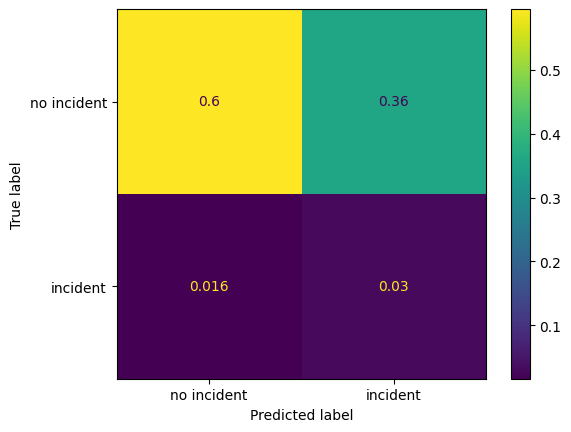

In [15]:
predictions=model.predict(testing_features)

precision=precision_score(testing_labels, predictions)
recall=recall_score(testing_labels, predictions)
print(f'Precision: {precision_score:.3f}')
print(f'Recall: {recall:.3f}\n')

cm=confusion_matrix(testing_labels, predictions, normalize='all')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no incident', 'incident'])
_=cm_disp.plot()

OK, we have 0.016 false negative rate, which means we are missing some disasters, and a 0.36 false positive rate - that's a lot of false alarms! Let's try a better model.

## 4. LSTM model

### 4.1. Model definition function

In [21]:
# Helper function to build model
def build_lstm(training_features: np.array, learning_rate: float=0.0001) -> keras.models.Sequential:
    '''Builds and compiles LSTM model'''

    # Define and adapt a normalization layer.
    norm_layer=keras.layers.Normalization()
    norm_layer.adapt(training_features)

    # Define the model
    model=Sequential()
    model.add(layers.Input((training_features.shape[1],training_features.shape[2])))
    model.add(norm_layer)
    model.add(layers.LSTM(256, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.LSTM(256))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the optimizer
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra metrics to evaluate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['recall', 'precision'])

    return model

### 4.2. Training function

In [22]:
# Helper function to train model
def train_lstm(
        model: keras.models.Sequential,
        training_features: np.array,
        training_labels: np.array,
        testing_features: np.array,
        testing_labels: np.array,
        epochs: int=10,
        batch_size: int=64
):
    
    '''Does one LSTM training run'''

    # Class weighting scheme suggested in a Tensorflow tutorial   
    pos_examples=training_labels.sum()
    neg_examples=len(training_labels) - pos_examples
    neg_class_weight=(1 / neg_examples) * (len(training_labels) / 2.0)
    pos_class_weight=(1 / pos_examples) * (len(training_labels) / 2.0)
    class_weight={0: neg_class_weight, 1: pos_class_weight}

    # Train the model
    result=model.fit(
        training_features,
        training_labels,
        validation_data=(testing_features, testing_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        class_weight=class_weight
    )

    return result, model

### 4.3. Training curve plot function

In [23]:
# Define a re-useable helper function that plots the results of a single training run
def plot_single_training_run(training_results):
    '''Takes a training results dictionary, plots it.'''

    # Set-up a 2x2 figure for metrics
    fig, axs=plt.subplots(1,2, figsize=(8,4))
    axs=axs.flatten()

    # Add the main title
    fig.suptitle('LSTM training curves', size='large')

    # Plot training and validation recall
    axs[0].set_title('Recall')
    axs[0].plot(training_results.history['recall'], label='Training')
    axs[0].plot(training_results.history['val_recall'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Recall score')
    axs[0].legend(loc='lower right')

    # Plot training and validation precision
    axs[1].set_title('Precision')
    axs[1].plot(training_results.history['precision'])
    axs[1].plot(training_results.history['val_precision'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Precision score')

    # Show the plot
    plt.tight_layout()

    return plt

### 4.4. Baseline LSTM training run

Training features: (32424, 6, 63)
Training labels: (32424,), 4.8% positive class
Testing features: (10808, 6, 63)
Testing labels: (10808,), 4.7% positive class


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 6, 63)          │           127 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 256)         │       327,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,384 (3.42 MB)

 Trainable params: 896,257 (3.42 MB)

 Non-trainable params: 127 (512.00 B)

Epoch 1/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step - loss: 0.6914 - precision: 0.0470 - recall: 0.4884 - val_loss: 0.6898 - val_precision: 0.0554 - val_recall: 0.4549
Epoch 2/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - loss: 0.6800 - precision: 0.0531 - recall: 0.5306 - val_loss: 0.6895 - val_precision: 0.0656 - val_recall: 0.5961
Epoch 3/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - loss: 0.6905 - precision: 0.0591 - recall: 0.5763 - val_loss: 0.6886 - val_precision: 0.0684 - val_recall: 0.6627
Epoch 4/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - loss: 0.6771 - precision: 0.0606 - recall: 0.5792 - val_loss: 0.6885 - val_precision: 0.0697 - val_recall: 0.6765
Epoch 5/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - loss: 0.6799 - precision: 0.0679 - recall: 0.6471 - val_loss: 0.6892 - val_precision: 0.0712 - val_recall: 0.7039
Epoch 6/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - loss: 0.6849 - precision: 0.0720 - recall: 0.6872 - val_loss: 0.6887 - val_precision: 0.0720 -

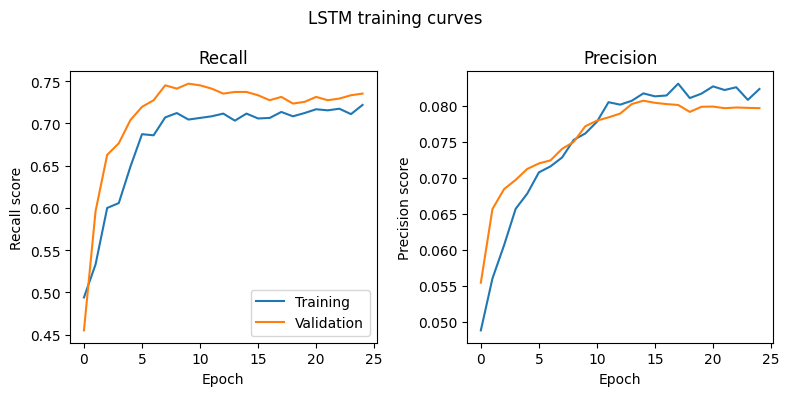



CPU times: user 21min 5s, sys: 56.2 s, total: 22min 2s
Wall time: 16min 22s


In [24]:
%%time

# Generate feature, label pairs
input_window=6
features, labels=generate_data(data_df, input_window)

# Split them into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(features, labels)
print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')

model=build_lstm(training_features, learning_rate=0.00001)
model.summary()

result, model=train_lstm(
    model,
    training_features,
    training_labels,
    testing_features,
    testing_labels,
    epochs=25
)

plot_single_training_run(result).show()

print('\n')

### 4.5. Evaluate baseline LSTM model

In [25]:
threshold=0.5
predictions=model.predict(testing_features)
calls=np.where(predictions > threshold, 1, 0)
predictions_df=pd.DataFrame.from_dict({'labels': testing_labels.flatten(), 'probabilities': predictions.flatten(), 'predicted_labels': calls.flatten()})
predictions_df.head()

338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


,labels,probabilities,predicted_labels
0,0,0.596945,1
1,0,0.493640,0
2,0,0.412140,0
3,0,0.321740,0
4,0,0.660605,1


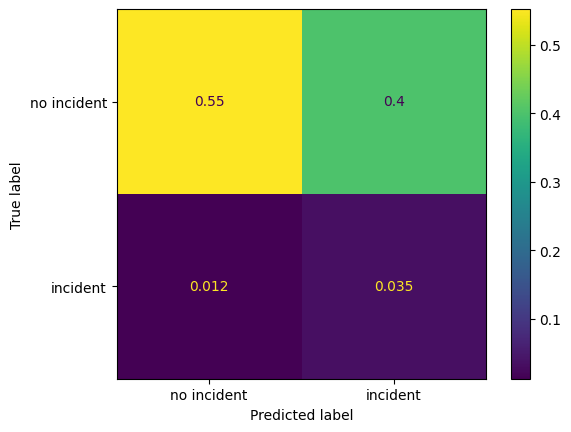

In [26]:
cm=confusion_matrix(testing_labels, calls, normalize='all')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no incident', 'incident'])
_=cm_disp.plot()

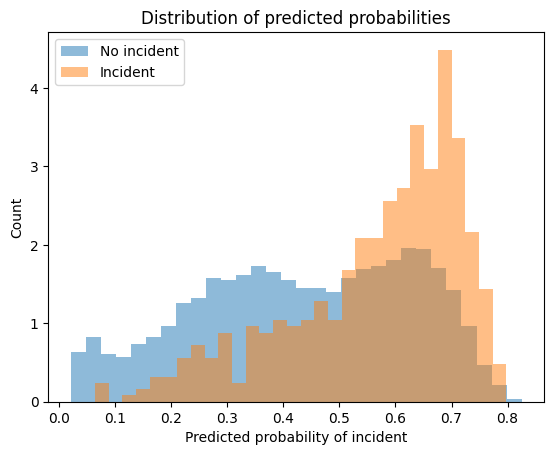

In [27]:
plt.title('Distribution of predicted probabilities')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 0], bins=30, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 1], bins=30, density=True, alpha=0.5, label='Incident')
plt.xlabel('Predicted probability of incident')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

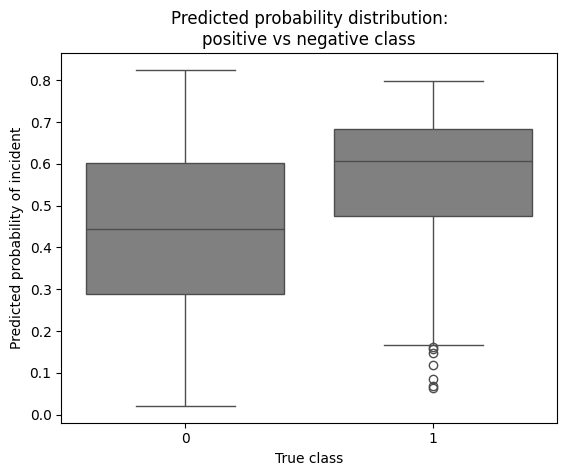

In [28]:
plt.title('Predicted probability distribution:\npositive vs negative class')
sns.boxplot(predictions_df, x='labels', y='probabilities', color='gray')
plt.xlabel('True class')
plt.ylabel('Predicted probability of incident')
plt.show()

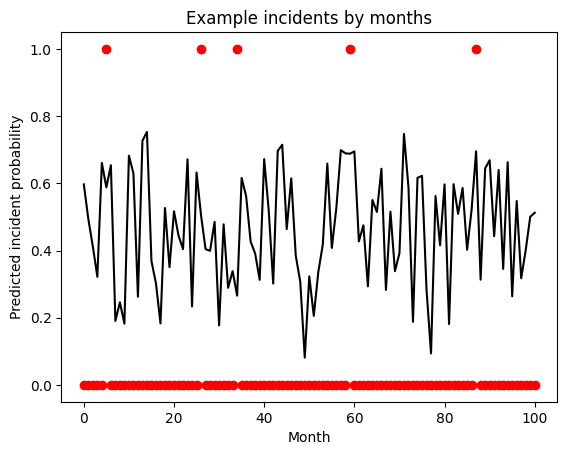

In [29]:
plt.title('Example incidents by months')
plt.plot(list(range(101)), predictions_df.loc[:100,'probabilities'], color='black', label='Predicted incident probability')
plt.scatter(list(range(101)), predictions_df.loc[:100,'labels'], color='red', label='True incidents')
plt.xlabel('Month')
plt.ylabel('Predicted incident probability')
plt.show()